# Optuna hyper parameter optimization
Here we have used small samples for better resourse management

In [1]:
# !pip install torch # for Model inference
# !pip install transformers # for Tokenization
# !pip install Optuna


import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaForSequenceClassification
from transformers import RobertaTokenizerFast


In [3]:
# Clear GPU memory and cache
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Clear memory
gc.collect()

# Print GPU memory stats to verify
print("GPU Memory Status:")
print(f"Allocated: {torch.cuda.memory_allocated(0) // 1024**2}MB")
print(f"Cached: {torch.cuda.memory_reserved(0) // 1024**2}MB")

GPU Memory Status:
Allocated: 0MB
Cached: 0MB


In [4]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Device name: NVIDIA GeForce RTX 5080


# Data Loading and Distribution

Vulnerability Distribution:
vul
0    177736
1      8794
Name: count, dtype: int64


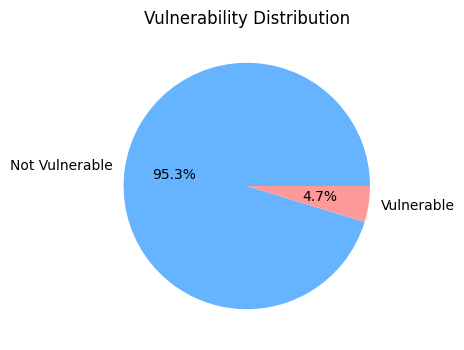

In [6]:
with open('data.json', 'r') as f:
    data = json.load(f)

#build DataFrame
df = pd.DataFrame(data)

# Value counts
vul_counts = df['vul'].value_counts()

# Print raw counts
print("Vulnerability Distribution:")
print(vul_counts)

# Plot pie chart
plt.figure(figsize=(4,4))
vul_counts.plot.pie(autopct='%1.1f%%', labels=['Not Vulnerable', 'Vulnerable'], colors=['#66b3ff','#ff9999'])
plt.title('Vulnerability Distribution')
plt.ylabel('')
plt.show()

# Splitting Dataset to test and train_val so we dont mess up the test dataset

In [18]:
#small dataset, 
not_touched_df,small_df=train_test_split(df,test_size=0.2,random_state=42)

vul_counts=small_df['vul'].value_counts()
print(vul_counts)

vul
0    35529
1     1777
Name: count, dtype: int64


Vulnerability Distribution:
vul
0    159980
1      7897
Name: count, dtype: int64


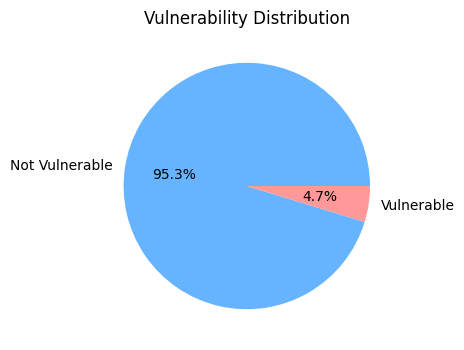

In [ ]:
#data splitting
from sklearn.model_selection import train_test_split

# keep 10% for test data about 17000 samples
train_val_ds, test_dataset = train_test_split(data, test_size=0.1, random_state=42)

# Convert to DataFrame
train_val_df = pd.DataFrame(train_val_ds)

# Show first few rows
train_val_df.head()

# Value counts
vul_counts = train_val_df['vul'].value_counts()

# Print raw counts
print("Vulnerability Distribution:")
print(vul_counts)

# Plot pie chart
plt.figure(figsize=(4,4))
vul_counts.plot.pie(autopct='%1.1f%%', labels=['Not Vulnerable', 'Vulnerable'], colors=['#66b3ff','#ff9999'])
plt.title('Vulnerability Distribution')
plt.ylabel('')
plt.show()

In [7]:
# test data
# Convert to DataFrame
test_df = pd.DataFrame(test_dataset)

# Show first few rows
test_df.head()

# Value counts
vul_counts = test_df['vul'].value_counts()

# Print raw counts
print("Vulnerability Distribution:")
print(vul_counts)



Vulnerability Distribution:
vul
0    17756
1      897
Name: count, dtype: int64


In [8]:
#build up validation data

temp_dataset, validation_dataset = train_test_split(train_val_ds, test_size=0.1, random_state=42)

vul_counts = pd.DataFrame(validation_dataset)['vul'].value_counts()
print(vul_counts)

vul
0    1601
1      78
Name: count, dtype: int64


# Experiment for making the training dataset balanced





Vulnerability Distribution:
vul
1    3000
0    3000
Name: count, dtype: int64


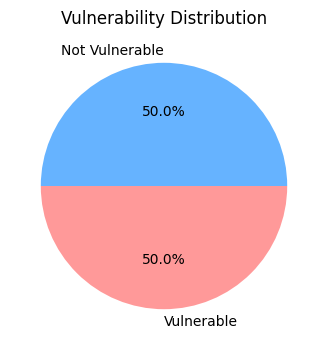

In [9]:
from sklearn.utils import resample

temp_df = pd.DataFrame(temp_dataset)
# Data sampling
df_vulnerable = temp_df[temp_df['vul'] == 1]
df_not_vulnerable = temp_df[temp_df['vul'] == 0]

# equal samples of vulnerable and non-vulnerable codes
n_samples=3000
vul_samples = resample(df_vulnerable, replace=False, n_samples=n_samples, random_state=42)
not_vul_samples = resample(df_not_vulnerable, replace=False, n_samples=n_samples, random_state=42)

balanced_df = pd.concat([vul_samples, not_vul_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Value counts
balanced_vul = balanced_df['vul'].value_counts()

# Print raw counts
print("Vulnerability Distribution:")
print(balanced_vul)

# Plot pie chart
plt.figure(figsize=(4,4))
balanced_vul.plot.pie(autopct='%1.1f%%', labels=['Not Vulnerable', 'Vulnerable'], colors=['#66b3ff','#ff9999'])
plt.title('Vulnerability Distribution')
plt.ylabel('')
plt.show()

In [10]:
train_dataset = balanced_df.to_dict(orient='records')
print(train_dataset[0])
print(train_dataset[1])

{'code': '   PropertyTreeState LayerState() {\n    DEFINE_STATIC_REF(\n        TransformPaintPropertyNode, transform,\n        CreateTransform(TransformPaintPropertyNode::Root(),\n                        TransformationMatrix().Translate(123, 456),\n                        FloatPoint3D(1, 2, 3)));\n    DEFINE_STATIC_REF(ClipPaintPropertyNode, clip,\n                      CreateClip(ClipPaintPropertyNode::Root(), transform,\n                                 FloatRoundedRect(12, 34, 56, 78)));\n    DEFINE_STATIC_REF(\n        EffectPaintPropertyNode, effect,\n        EffectPaintPropertyNode::Create(\n            EffectPaintPropertyNode::Root(),\n            EffectPaintPropertyNode::State{\n                transform, clip, kColorFilterLuminanceToAlpha,\n                CompositorFilterOperations(), 0.789f, SkBlendMode::kSrcIn}));\n    return PropertyTreeState(transform, clip, effect);\n   }\n', 'vul': 1, 'flaw_line_no': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'bigvul_id':

In [11]:
class CodeBERTDataset(Dataset):
    def __init__(self, codes, tokenizer, max_length):
      self.data=codes
      self.tokenizer=tokenizer
      self.max_len=max_length


    def __len__(self):
      """Tells PyTorch how many examples are in the dataset."""
      return len(self.data)


    def __getitem__(self,idx):
      """Gets a single function at idx from the dataset."""
      item=self.data[idx]
      code=item["code"]
      vul=item["vul"]
      flaw_line_no=item["flaw_line_no"]


      enc=self.tokenizer(
          code,
          add_special_tokens=True,
          max_length=self.max_len,
          padding="max_length",
          truncation=True,
          return_tensors="pt",
          return_offsets_mapping=True
      )

      return {
        "input_ids": enc["input_ids"].squeeze(0),     #removes the batch dimension (the 1 in [1,512]), giving you a 1-D tensor of length 512
        "attention_mask": enc["attention_mask"].squeeze(0),
        "labels": torch.tensor(vul, dtype=torch.long),
        "code": code,
        "offset_mapping": enc["offset_mapping"].squeeze(0), #start and end index of each token
        "flaw_line_no": flaw_line_no
      }


def custom_collate_fn(batch):
    # This function will receive a list of dictionaries, where each dictionary
    # corresponds to one sample returned by __getitem__
    collated_batch = {}

    # Tensors that can be stacked directly
    collated_batch["input_ids"] = torch.stack([item["input_ids"] for item in batch])
    collated_batch["attention_mask"] = torch.stack([item["attention_mask"] for item in batch])
    collated_batch["labels"] = torch.stack([item["labels"] for item in batch])
    collated_batch["offset_mapping"] = torch.stack([item["offset_mapping"] for item in batch])

    # Items that are not tensors and should not be stacked (kept as lists)
    collated_batch["code"] = [item["code"] for item in batch]
    collated_batch["flaw_line_no"] = [item["flaw_line_no"] for item in batch] # Keep as list of lists

    return collated_batch

In [ ]:
tokenizer=RobertaTokenizerFast.from_pretrained("microsoft/codebert-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base",
                                                       num_labels=2).to(device)


# Fine tuneing with Optuna

In [12]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners  import MedianPruner
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef
import copy


In [15]:
def objective(trial):
    # Clear GPU cache
    torch.cuda.empty_cache()

    print("-----------------------------------------")
    print("Starting trial:", trial.number)
    # Sample hyper-parameters
    lr  = trial.suggest_categorical("learning_rate", [2e-6,1e-5,3e-5,5e-5,2e-4]) 
    bs  = trial.suggest_categorical("batch_size", [8,16,32]) # 8,16
    wd  = trial.suggest_categorical("weight_decay", [0.0,0.01,0.1])  #0 an 0.01
    msl = trial.suggest_categorical("max_seq_length", [512])
    max_epochs=8
    patience=2

    # model & optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = RobertaTokenizerFast.from_pretrained("microsoft/codebert-base")
    model  = RobertaForSequenceClassification.from_pretrained(
                 "microsoft/codebert-base", num_labels=2
             ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    # Prepare data

    train_ds  = CodeBERTDataset(train_dataset, tokenizer, msl)
    val_ds    = CodeBERTDataset(validation_dataset,   tokenizer, msl)
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,collate_fn=custom_collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False,collate_fn=custom_collate_fn)

    # early stop and pruning setup
    best_val_f1 = 0.0
    best_weights=copy.deepcopy(model.state_dict())
    wait= 0

    #Training + validation loop
    for epoch in range(max_epochs):

        model.train()
        train_loss = []
        train_preds, train_labels = [], []

        #train
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
            out.loss.backward()
            optimizer.step()
            train_loss.append(out.loss.item())
            preds = out.logits.argmax(dim=1).cpu().tolist()
            train_preds.extend(preds)
            train_labels.extend(batch["labels"].tolist())

        # compute training metrics
        train_loss=sum(train_loss)/len(train_loss)
        train_acc=accuracy_score(train_labels, train_preds)

        #Validation
        model.eval()
        val_loss=[]
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                out = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                val_loss.append(out.loss.item())
                preds = out.logits.argmax(dim=1).cpu()

                val_preds.extend(preds)
                val_labels.extend(batch["labels"].tolist())

        # compute val‐set metrics
        val_loss = sum(val_loss) / len(val_loss)
        val_acc = accuracy_score(val_labels, val_preds)
        val_prec = precision_score(val_labels, val_preds, zero_division=0)
        val_rec = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)
        val_mcc = matthews_corrcoef(val_labels, val_preds)

        # pruning
        trial.report(val_f1, step=epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        #Early‐stopping logic
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_weights = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early‐stopping at epoch {epoch + 1}")
                break

        # epoch‐level log
        print(f"[Trial {trial.number} | Epoch {epoch + 1}]",
              f"train_loss={train_loss:.4f}", f"train_acc={train_acc:.3f}",
              f"val_loss={val_loss:.4f}", f"val_acc={val_acc:.3f}",
              f"val_f1={val_f1:.3f}", f"val_prec={val_prec:.3f}",
              f"val_rec={val_rec:.3f}", f"val_mcc={val_mcc:.3f}")


    # restore best model weights before returning
    model.load_state_dict(best_weights)
    return best_val_f1


#Create & run study
study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(seed=42),
                            pruner=MedianPruner(n_startup_trials=5, interval_steps=1)
                            )
study.optimize(objective, n_trials=15)

print("Best params:", study.best_trial.params)
print("Best Val F1:", study.best_trial.value)



[I 2025-06-01 11:08:05,364] A new study created in memory with name: no-name-9aee56ff-2653-43a1-b832-286d1e940e2b


-----------------------------------------
Starting trial: 0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 0 | Epoch 1] train_loss=0.5483 train_acc=0.719 val_loss=0.2060 val_acc=0.943 val_f1=0.518 val_prec=0.429 val_rec=0.654 val_mcc=0.501
[Trial 0 | Epoch 2] train_loss=0.3350 train_acc=0.860 val_loss=0.2151 val_acc=0.936 val_f1=0.542 val_prec=0.405 val_rec=0.821 val_mcc=0.549
[Trial 0 | Epoch 3] train_loss=0.2987 train_acc=0.880 val_loss=0.2175 val_acc=0.939 val_f1=0.538 val_prec=0.414 val_rec=0.769 val_mcc=0.537
[Trial 0 | Epoch 4] train_loss=0.2811 train_acc=0.885 val_loss=0.2060 val_acc=0.937 val_f1=0.551 val_prec=0.411 val_rec=0.833 val_mcc=0.559
[Trial 0 | Epoch 5] train_loss=0.2634 train_acc=0.894 val_loss=0.2030 val_acc=0.937 val_f1=0.557 val_prec=0.415 val_rec=0.846 val_mcc=0.566
[Trial 0 | Epoch 6] train_loss=0.2373 train_acc=0.903 val_loss=0.2810 val_acc=0.904 val_f1=0.464 val_prec=0.312 val_rec=0.897 val_mcc=0.496
[Trial 0 | Epoch 7] train_loss=0.2171 train_acc=0.916 val_loss=0.1401 val_acc=0.958 val_f1=0.643 val_prec=0.529 val_rec=0.821 val_mcc=0.639


[I 2025-06-01 11:25:07,531] Trial 0 finished with value: 0.6432160804020101 and parameters: {'learning_rate': 1e-05, 'batch_size': 32, 'weight_decay': 0.01, 'max_seq_length': 512}. Best is trial 0 with value: 0.6432160804020101.


[Trial 0 | Epoch 8] train_loss=0.1963 train_acc=0.923 val_loss=0.2065 val_acc=0.939 val_f1=0.562 val_prec=0.420 val_rec=0.846 val_mcc=0.571
-----------------------------------------
Starting trial: 1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 1 | Epoch 1] train_loss=0.6309 train_acc=0.659 val_loss=0.4500 val_acc=0.795 val_f1=0.235 val_prec=0.142 val_rec=0.679 val_mcc=0.243
[Trial 1 | Epoch 2] train_loss=0.4615 train_acc=0.794 val_loss=0.2263 val_acc=0.929 val_f1=0.487 val_prec=0.365 val_rec=0.731 val_mcc=0.485
[Trial 1 | Epoch 3] train_loss=0.3414 train_acc=0.858 val_loss=0.1704 val_acc=0.957 val_f1=0.600 val_prec=0.529 val_rec=0.692 val_mcc=0.584
[Trial 1 | Epoch 4] train_loss=0.3164 train_acc=0.871 val_loss=0.2135 val_acc=0.937 val_f1=0.529 val_prec=0.407 val_rec=0.756 val_mcc=0.527


[I 2025-06-01 11:35:52,305] Trial 1 finished with value: 0.6 and parameters: {'learning_rate': 2e-06, 'batch_size': 16, 'weight_decay': 0.01, 'max_seq_length': 512}. Best is trial 0 with value: 0.6432160804020101.


Early‐stopping at epoch 5
-----------------------------------------
Starting trial: 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 2 | Epoch 1] train_loss=0.6930 train_acc=0.526 val_loss=0.7539 val_acc=0.046 val_f1=0.089 val_prec=0.046 val_rec=1.000 val_mcc=0.000
[Trial 2 | Epoch 2] train_loss=0.6981 train_acc=0.508 val_loss=0.7155 val_acc=0.046 val_f1=0.089 val_prec=0.046 val_rec=1.000 val_mcc=0.000


[I 2025-06-01 11:42:17,931] Trial 2 finished with value: 0.0887877063175868 and parameters: {'learning_rate': 5e-05, 'batch_size': 16, 'weight_decay': 0.0, 'max_seq_length': 512}. Best is trial 0 with value: 0.6432160804020101.


Early‐stopping at epoch 3
-----------------------------------------
Starting trial: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 3 | Epoch 1] train_loss=0.4688 train_acc=0.770 val_loss=0.1846 val_acc=0.946 val_f1=0.531 val_prec=0.447 val_rec=0.654 val_mcc=0.514
[Trial 3 | Epoch 2] train_loss=0.3162 train_acc=0.865 val_loss=0.1820 val_acc=0.949 val_f1=0.594 val_prec=0.470 val_rec=0.808 val_mcc=0.593
[Trial 3 | Epoch 3] train_loss=0.2542 train_acc=0.900 val_loss=0.2296 val_acc=0.911 val_f1=0.464 val_prec=0.322 val_rec=0.833 val_mcc=0.484


[I 2025-06-01 11:51:10,634] Trial 3 finished with value: 0.5943396226415094 and parameters: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.1, 'max_seq_length': 512}. Best is trial 0 with value: 0.6432160804020101.


Early‐stopping at epoch 4
-----------------------------------------
Starting trial: 4


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 4 | Epoch 1] train_loss=0.5174 train_acc=0.746 val_loss=0.3538 val_acc=0.867 val_f1=0.372 val_prec=0.238 val_rec=0.846 val_mcc=0.405
[Trial 4 | Epoch 2] train_loss=0.3245 train_acc=0.865 val_loss=0.2879 val_acc=0.912 val_f1=0.471 val_prec=0.327 val_rec=0.846 val_mcc=0.492
[Trial 4 | Epoch 3] train_loss=0.2805 train_acc=0.891 val_loss=0.1905 val_acc=0.956 val_f1=0.615 val_prec=0.518 val_rec=0.756 val_mcc=0.604
[Trial 4 | Epoch 4] train_loss=0.2455 train_acc=0.902 val_loss=0.2154 val_acc=0.937 val_f1=0.557 val_prec=0.415 val_rec=0.846 val_mcc=0.566


[I 2025-06-01 12:01:52,756] Trial 4 finished with value: 0.6145833333333334 and parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'max_seq_length': 512}. Best is trial 0 with value: 0.6432160804020101.


Early‐stopping at epoch 5
-----------------------------------------
Starting trial: 5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:04:01,510] Trial 5 pruned. 


-----------------------------------------
Starting trial: 6


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:06:11,110] Trial 6 pruned. 


-----------------------------------------
Starting trial: 7


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:08:25,051] Trial 7 pruned. 


-----------------------------------------
Starting trial: 8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:10:34,179] Trial 8 pruned. 


-----------------------------------------
Starting trial: 9


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 9 | Epoch 1] train_loss=0.4610 train_acc=0.779 val_loss=0.2883 val_acc=0.886 val_f1=0.396 val_prec=0.263 val_rec=0.808 val_mcc=0.419
[Trial 9 | Epoch 2] train_loss=0.3266 train_acc=0.868 val_loss=0.2004 val_acc=0.937 val_f1=0.549 val_prec=0.413 val_rec=0.821 val_mcc=0.555
[Trial 9 | Epoch 3] train_loss=0.2703 train_acc=0.889 val_loss=0.2800 val_acc=0.899 val_f1=0.439 val_prec=0.296 val_rec=0.846 val_mcc=0.464


[I 2025-06-01 12:19:23,177] Trial 9 finished with value: 0.5493562231759657 and parameters: {'learning_rate': 3e-05, 'batch_size': 8, 'weight_decay': 0.0, 'max_seq_length': 512}. Best is trial 0 with value: 0.6432160804020101.


Early‐stopping at epoch 4
-----------------------------------------
Starting trial: 10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:21:31,879] Trial 10 pruned. 


-----------------------------------------
Starting trial: 11


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 11 | Epoch 1] train_loss=0.5369 train_acc=0.733 val_loss=0.2344 val_acc=0.925 val_f1=0.492 val_prec=0.359 val_rec=0.782 val_mcc=0.498


[I 2025-06-01 12:25:50,560] Trial 11 pruned. 


-----------------------------------------
Starting trial: 12


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:27:58,911] Trial 12 pruned. 


-----------------------------------------
Starting trial: 13


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Trial 13 | Epoch 1] train_loss=0.5128 train_acc=0.742 val_loss=0.2634 val_acc=0.895 val_f1=0.401 val_prec=0.273 val_rec=0.756 val_mcc=0.414
[Trial 13 | Epoch 2] train_loss=0.3221 train_acc=0.866 val_loss=0.2065 val_acc=0.932 val_f1=0.517 val_prec=0.386 val_rec=0.782 val_mcc=0.520
[Trial 13 | Epoch 3] train_loss=0.2824 train_acc=0.887 val_loss=0.2088 val_acc=0.933 val_f1=0.537 val_prec=0.396 val_rec=0.833 val_mcc=0.547
[Trial 13 | Epoch 4] train_loss=0.2423 train_acc=0.903 val_loss=0.1860 val_acc=0.938 val_f1=0.552 val_prec=0.416 val_rec=0.821 val_mcc=0.557
[Trial 13 | Epoch 5] train_loss=0.2157 train_acc=0.913 val_loss=0.1842 val_acc=0.937 val_f1=0.549 val_prec=0.413 val_rec=0.821 val_mcc=0.555
[Trial 13 | Epoch 6] train_loss=0.1804 train_acc=0.929 val_loss=0.1310 val_acc=0.961 val_f1=0.656 val_prec=0.559 val_rec=0.795 val_mcc=0.647
[Trial 13 | Epoch 7] train_loss=0.1438 train_acc=0.945 val_loss=0.1899 val_acc=0.939 val_f1=0.558 val_prec=0.419 val_rec=0.833 val_mcc=0.565


[I 2025-06-01 12:45:10,443] Trial 13 finished with value: 0.656084656084656 and parameters: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'max_seq_length': 512}. Best is trial 13 with value: 0.656084656084656.


Early‐stopping at epoch 8
-----------------------------------------
Starting trial: 14


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-01 12:47:19,269] Trial 14 pruned. 


Best params: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.01, 'max_seq_length': 512}
Best Val F1: 0.656084656084656


In [16]:
# 1) Print optimization history
print("\nOptimization History:")
print("-" * 50)
for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"Value (F1): {trial.value}")
    print(f"Params: {trial.params}")
    print("-" * 30)

# 2) Print best trial
print("\nBest Trial:")
print("-" * 50)
print(f"Value (F1): {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


Optimization History:
--------------------------------------------------
Trial 0:
Value (F1): 0.6432160804020101
Params: {'learning_rate': 1e-05, 'batch_size': 32, 'weight_decay': 0.01, 'max_seq_length': 512}
------------------------------
Trial 1:
Value (F1): 0.6
Params: {'learning_rate': 2e-06, 'batch_size': 16, 'weight_decay': 0.01, 'max_seq_length': 512}
------------------------------
Trial 2:
Value (F1): 0.0887877063175868
Params: {'learning_rate': 5e-05, 'batch_size': 16, 'weight_decay': 0.0, 'max_seq_length': 512}
------------------------------
Trial 3:
Value (F1): 0.5943396226415094
Params: {'learning_rate': 1e-05, 'batch_size': 8, 'weight_decay': 0.1, 'max_seq_length': 512}
------------------------------
Trial 4:
Value (F1): 0.6145833333333334
Params: {'learning_rate': 1e-05, 'batch_size': 16, 'weight_decay': 0.0, 'max_seq_length': 512}
------------------------------
Trial 5:
Value (F1): 0.15841584158415842
Params: {'learning_rate': 2e-06, 'batch_size': 32, 'weight_decay': 0.